## Import relevant python packages
#### python3 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar

## read csv file
1. set encoding to 'ISO'
2. parse 'InvoiceDate' field

In [2]:
data = pd.read_csv("data.csv",sep = ",",encoding = "ISO-8859-1",parse_dates = ['InvoiceDate'],infer_datetime_format=True)

## Prepare Dataset
1. split 'InvoiceDate' filed into corresponding date and time as it helps in later queries
2. check for NaN values


In [3]:
data['InvoiceTime'] = data['InvoiceDate'].dt.time
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'].dt.date)

In [4]:
data.columns[data.isnull().any()].tolist()

['Description', 'CustomerID']

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,08:26:00


In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
InvoiceTime         0
dtype: int64

In [7]:
data.shape

(541909, 9)

### determine number of unique items in the dataset

In [8]:
uninque_stocks = data['StockCode'].groupby([data.StockCode.str.strip("'")]).nunique()

In [9]:
uninque_stocks.shape

(4070,)

#### Determine the number of quanties of each item sold during 2010 and 2011

In [10]:
stocks_quatity = pd.DataFrame({'count' : data.groupby(['StockCode'])['Quantity'].sum()}).reset_index()


In [11]:
stocks_quatity.head()

,StockCode,count
0,10002,1037
1,10080,495
2,10120,193
3,10123C,-13
4,10123G,-38


#### select top-k popular items

In [12]:
top_k = 10
df_top_k_stocks = stocks_quatity.sort_values(by = 'count',ascending=False).head(top_k)

In [13]:
df_top_k_stocks

,StockCode,count
1147,22197,56450
2997,84077,53847
3515,85099B,47363
3536,85123A,38830
3305,84879,36221
454,21212,36039
1982,23084,30646
1412,22492,26437
1530,22616,26315
966,21977,24753


In [14]:
def visualize_top_k_items(df):
    ind = np.arange(0,df.shape[0])
    width = 0.4   
    plt.clf()
    fig = plt.figure()

    ax  = fig.gca()
    cmap = sns.color_palette("RdBu_r", 7)
    p1 = ax.bar(ind,df['count'], width)
    ax.set_ylabel('Sales Quantity')
    ax.set_xlabel('Stock Code')
    ax.set_title('Top selling products',fontsize=20)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(df['StockCode'])
    fig.autofmt_xdate()
    plt.show()

<Figure size 432x288 with 0 Axes>

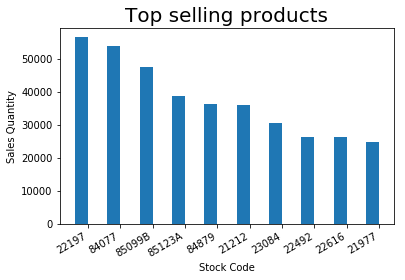

In [15]:
visualize_top_k_items(df_top_k_stocks)

## Time Series Analysis
1. Determine and visualize the top selling items on yearly basis
2. Determine and visualize the performance of top-k items on yearly basis
3. Determine and visualize the performance of top-k items on montly basis
4. Determine items which generate maximum revenue

### 1. Determine and visualize the top selling items on yearly basis

In [16]:
stocks_date_quatity = pd.DataFrame({'count' : data.groupby([data.InvoiceDate.dt.year,data.StockCode])['Quantity'].sum()}).reset_index()
stocks_date_quatity.sort_values(by = 'count',inplace = True,ascending = False)
years = stocks_date_quatity.InvoiceDate.unique()

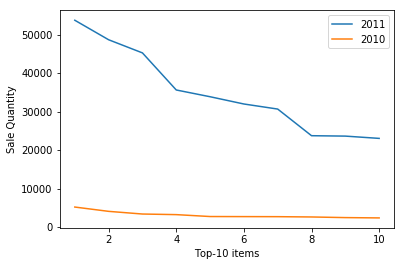

In [17]:
top_k = 10
for y in years:
    stock_top_y = stocks_date_quatity[stocks_date_quatity.InvoiceDate == y].head(top_k)
    x = np.arange(1,stock_top_y.shape[0]+1)
    plt.plot(x,stock_top_y['count'],label = str(y))

plt.xlabel("Top-"+str(top_k)+' items')
plt.ylabel("Sale Quantity")
plt.legend()    

### 2. Determine and visualize the performance of top-k items on yearly basis
The following plot illustrates that sales were negligible in 2010 and drastically improved in 2011

In [18]:
top_selling_item_ids = df_top_k_stocks['StockCode'].reset_index(drop = True)
top_items_yrly = stocks_date_quatity.loc[stocks_date_quatity['StockCode'].isin(top_selling_item_ids)]
top_items_yrly_agg  = pd.DataFrame({'count' : top_items_yrly.groupby(by = ['InvoiceDate','StockCode'])['count'].sum()}).reset_index()
top_items_yrly_agg = top_items_yrly_agg.pivot(index='StockCode', columns='InvoiceDate', values='count')
top_items_yrly_agg.fillna(0, inplace=True)

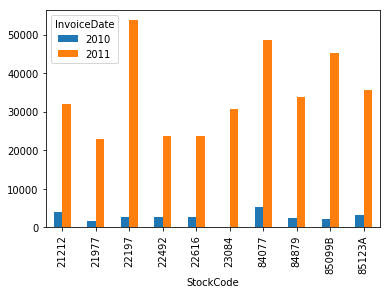

In [19]:
top_items_yrly_agg.plot.bar()

### 3. Determine and visualize the performance of top-k items on monthly basis
We try to explore to check if customers prefer any particular month over others. We find that November and December are two most favoured months which recorded sale of maximum quantity of items. Also, we find that January and February are the two least preffered months. This could be due to the Vacation time due to Christmas holidays.  

In [20]:
popular_items_data = data.loc[data['StockCode'].isin(top_selling_item_ids)]
popular_items_data['Invoice_month'] = popular_items_data.InvoiceDate.dt.month
popular_items_data_monthly = popular_items_data.groupby(by = [popular_items_data.InvoiceDate.dt.month,'StockCode'])['Quantity'].sum().reset_index()
popular_items_data_monthly['InvoiceDate'] = popular_items_data_monthly['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])
popular_items_data_monthly.sort_values(by = 'Quantity',inplace = True,ascending = False)
popular_items_data_monthly = popular_items_data_monthly.pivot(index='StockCode', columns='InvoiceDate', values='Quantity')
popular_items_data_monthly.fillna(0,inplace = True)




/home/sandeep/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


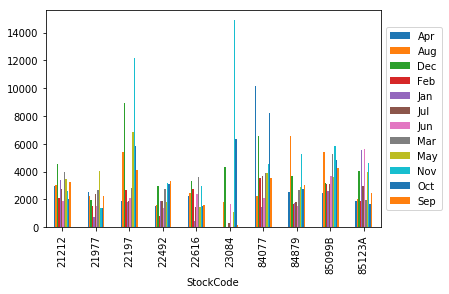

In [21]:
fig = plt.figure()
ax=fig.gca()
popular_items_data_monthly.plot(kind = 'bar',ax = ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [22]:
popular_items_data_monthly.sum()

InvoiceDate
Apr    28193.0
Aug    32772.0
Dec    43558.0
Feb    19989.0
Jan    19777.0
Jul    22381.0
Jun    23991.0
Mar    29683.0
May    33215.0
Nov    57483.0
Oct    37748.0
Sep    28111.0
dtype: float64

### 3. Find top-k revenue generating items
Determine total sales cost using 'Quantity' and 'UnitPrice' fields

In [23]:
data['Sale_Cost'] = data['Quantity']*data['UnitPrice']

In [24]:
high_val_customers = pd.DataFrame({'total_sale_cost': data.groupby(by = 'CustomerID')['Sale_Cost'].sum()}).reset_index()

In [25]:
high_val_customers.sort_values(by = 'total_sale_cost',inplace = True,ascending = False)

Text(0.5,1,'Top Revenue Generators')

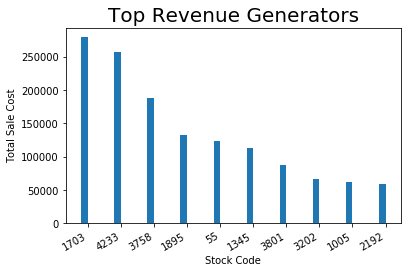

In [26]:
top_k = 10
high_val_customers_top_k = high_val_customers.head(10)
fig = plt.figure()
ax = fig.gca()
width = 0.2
x  = np.arange(0,high_val_customers_top_k.shape[0])
y  = high_val_customers_top_k['total_sale_cost'].values
ax.bar(x,y,width = 0.2)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(high_val_customers_top_k['CustomerID'].astype(int).index)
fig.autofmt_xdate()
ax.set_ylabel('Total Sale Cost')
ax.set_xlabel('Stock Code')
ax.set_title('Top Revenue Generators',fontsize=20)

### Determine Correlation between unit price and quantity sold
We find that there exists very weak linear relationship between unit price and Quantity sold  

In [27]:
data['UnitPrice'].corr(data['Quantity'])

-0.0012349245448702957

### Variation of the prices of goods according to the change time
The following plot illustrates how the average unit price across all items vary over time. From the plot, we find that
the average unit prices are very high in the morning and thereafter remain almost steady between 8.00 to 18.00. Finally, around 20.00 unit prices fall to very low value. 

In [28]:
data['InvoiceHour'] = data['InvoiceTime'].apply(lambda x: x.hour)

In [29]:
hourly_avg_orders = pd.DataFrame({'avg_unit__price_hourly' : data.groupby(by = 'InvoiceHour')['UnitPrice'].mean()})

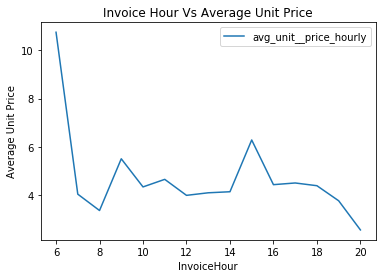

In [30]:
fig = plt.figure()
ax  = fig.gca()
ax.set_xlabel("Invoice Hour")
ax.set_ylabel("Average Unit Price")
ax.set_title("Invoice Hour Vs Average Unit Price")
hourly_avg_orders.plot(ax = ax)

### Checking if description has any effect on the price or sale of goods.
1. Add a new field 'Desc_NUM_WORDS' depending on the number of words in each item description
2. Replace missing entries as empty descriptions

In [31]:
data['Description'].fillna('',inplace = True)
data['Description'] = data['Description'].astype(str)
data['Desc_NUM_WORDS'] = data['Description'].apply(lambda x: len(x.split(" ")))

### The following plot illustrates that customers tend to prefer items that have 3 to 6 words in the description field.

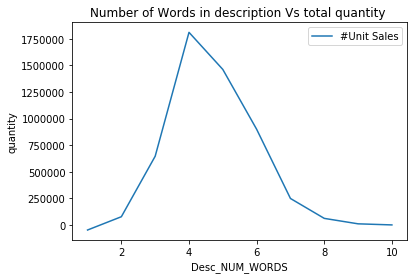

In [32]:
desc_len_avg_qty = pd.DataFrame({'#Unit Sales' : data.groupby(by = 'Desc_NUM_WORDS')['Quantity'].sum()})
fig = plt.figure()
ax  = fig.gca()
ax.set_xlabel("Number of Words in description")
ax.set_ylabel("quantity")
ax.set_title("Number of Words in description Vs total quantity ")
desc_len_avg_qty.plot(ax = ax)

### The following plot illustrates that items that have fewer words in the descriptions tend to have very high average per unit price

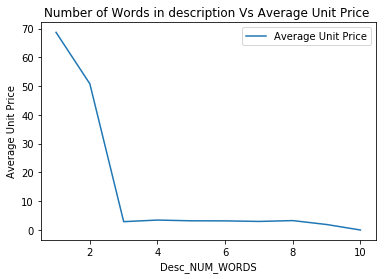

In [33]:
desc_len_avg_price = pd.DataFrame({'Average Unit Price' : data.groupby(by = 'Desc_NUM_WORDS')['UnitPrice'].mean()})
fig = plt.figure()
ax  = fig.gca()
ax.set_xlabel("Number of Words in description")
ax.set_ylabel("Average Unit Price")
ax.set_title("Number of Words in description Vs Average Unit Price ")
desc_len_avg_price.plot(ax = ax)